# analytical broadsword approach

- analytically tractable problem: Gaussian prior, Gaussian proposal, _linear-Gaussian likelihood_
- analytically tractable MDN: linear-affine network
- analytically tractable gradients and closed-form solution for MDN parameters for given dataset


TO DO:
- check gradients again
- seems like the proposal-adjusted finite-size effective joint distribution (eq. 4, p. 11 in JakobsNotes.pdf) is badly off right now (_currently not in use_!)
- type down the CDELFI version of the below stuff and import analytical division for direct comparison 


prior: 

$p(\theta) = \mathcal{N}(\theta \ | \ 0, \eta^2)$

proposal prior: 

$\tilde{p}(\theta) = \mathcal{N}(\theta \ | \ 0, \xi^2)$

simulator: 

$p(x \ | \ \theta) =  \mathcal{N}(x \ | \ \theta, \sigma^2)$

analytic posteriors: 

$p(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\eta^2}{\eta^2 + \sigma^2} x, \eta^2 - \frac{\eta^4}{\eta^2 + \sigma^2})$ 

$\tilde{p}(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\xi^2}{\xi^2 + \sigma^2} x, \xi^2 - \frac{\xi^4}{\xi^2 + \sigma^2})$

Data:

$(x_n, \theta_n) \sim p(\theta) p(x \ | \ \theta) = \mathcal{N}( (x_n, \theta_n) \ | \ (0, 0), 
\begin{pmatrix}
\xi^{2} + \sigma^{2} &  \xi^{2}  \\
\xi^{2} & \xi^{2}  \\
\end{pmatrix})$

Loss: 

$ \mathcal{L}(\phi) = \sum_n \frac{{p}(\theta_n)}{\tilde{p}(\theta_n)} K_\epsilon(x_n | x_0) \ \log q_\phi(\theta_n | x_n)$

Model: 

$ q_\phi(\theta_n | x_n) = \mathcal{N}(\theta_n \ | \ \mu_\phi(x_n), \sigma^2_\phi(x_n))$

$ (\mu_\phi(x), \sigma^2_\phi(x)) = MDN_\phi(x) = \begin{pmatrix} \beta \\ 0 \end{pmatrix} x + \begin{pmatrix} \alpha \\ \gamma^2 \end{pmatrix}$

Gradients: 

$\mathcal{N}_n := \mathcal{N}(x_n, \theta_n \ | \ \mu_y, \Sigma_y)$

$\Sigma_y = \frac{\sigma^2 \epsilon^2 (\eta^2 - \xi^2)}{\sigma^2 + \epsilon^2 + \eta^2 - \xi^2} 
\begin{pmatrix}
\frac{\sigma^2  + \eta^2 - \xi^2}{\sigma^2 ( \eta^2 - \xi^2 )}  &  - \frac{1}{\sigma^{2}}  \\
- \frac{1}{\sigma^{2}} & \frac{1}{\sigma^{2}} + \frac{1}{\epsilon^{2}}  \\
\end{pmatrix})$

$\mu_y = \Sigma_y  \begin{pmatrix} \frac{x_0^2}{\epsilon^2}  \\ 0 \end{pmatrix} = 
 \frac{x_0^2}{\sigma^2 + \epsilon^2 + \eta^2 - \xi^2}
 \begin{pmatrix} \sigma^2 + \eta^2 - \xi^2  \\ \eta^2 - \xi^2 \end{pmatrix}$

$\frac{\partial{}\mathcal{L}}{\partial{}\alpha} = -2 \sum_n \mathcal{N}_n \frac{\theta_n - \mu_\phi(x_n)}{\sigma^2_\phi(x_n)}$

$\frac{\partial{}\mathcal{L}}{\partial{}\beta} = -2 \sum_n \mathcal{N}_n \frac{\theta_n - \mu_\phi(x_n)}{\sigma^2_\phi(x_n)} x_n$

$\frac{\partial{}\mathcal{L}}{\partial{}\gamma^2} 
= \sum_n \mathcal{N}_n \left( \frac{1}{\sigma^2_\phi(x_n)} 
- \frac{\left(\theta_n - \mu_\phi(x_n) \right)^2}{\sigma^4_\phi(x_n)} \right) 
= \frac{1}{\gamma^2} \sum_n \mathcal{N}_n \left( 1 
- \frac{\left(\theta_n - \mu_\phi(x_n) \right)^2}{\gamma^2} \right) $

Optima: 

$\hat{\alpha} = 
\frac{\sum_n \mathcal{N}_n \left(\theta_n - \frac{\sum_m \mathcal{N}_m \theta_m x_m}{\sum_m \mathcal{N}_m x_m^2} x_n \right)}{\sum_n \mathcal{N}_n - \frac{\left( \sum_n \mathcal{N}_n x_n \right)^2}{\sum_n \mathcal{N}_n x_n^2}}$

$\hat{\beta} = 
\frac{\sum_n \mathcal{N}_n \theta_n x_n - \hat{\alpha} \sum_n \mathcal{N}_n x_n}{\sum_n \mathcal{N}_n x_n^2}$

$\hat{\gamma}^2 = 
\frac{\sum_n \mathcal{N}_n \left( \theta_n - \hat{\alpha} - \hat{\beta} x_n \right)^2}{\sum_n \mathcal{N}_n}$

In [1]:
%%capture
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.stats import multivariate_normal as mvn

from delfi.simulator.Gauss import Gauss


n_params = 1
seed = 42

sig2 = 1.
eta2 = 1.0
ksi2 = 0.5
eps2 = 1e20

assert n_params ==  1
m = Gauss(dim=n_params, seed=seed, noise_cov=sig2)
p = dd.Gaussian(m=0. * np.ones(n_params), 
                S=eta2 * np.eye(n_params),
                seed=seed)


ppr = dd.Gaussian(m=0. * np.ones(n_params), 
                S=ksi2 * np.eye(n_params),
                seed=seed)


x0 = 0.8 * np.ones((1,1)) #_,obs = g.gen(1)

post   = dd.Gaussian(m = np.ones(n_params) * eta2/(eta2+sig2)*x0[0], S=eta2 - eta2**2 / (eta2 + sig2) * np.eye(n_params))
postpr = dd.Gaussian(m = np.ones(n_params) * ksi2/(ksi2+sig2)*x0[0], S=ksi2 - ksi2**2 / (ksi2 + sig2) * np.eye(n_params))

s = ds.Identity()
g = dg.Default(model=m, prior=p, summary=s)

mu_y = np.array([[sig2 + eta2 - ksi2], [eta2 - ksi2]]) * x0**2 / (sig2 + eps2 + eta2 - ksi2)

Sig_y = np.array([[(sig2+eta2-ksi2)/(sig2*(eta2-ksi2)), -1/sig2], 
                  [-1/sig2, 1/sig2 + 1/eps2] ]) * sig2 * eps2 * (eta2 - ksi2) / (sig2 + eps2 + eta2 - ksi2)


def gauss_weights(params, stats, mu_y, Sig_y):
    
    y = np.hstack((stats, params))
    return mvn.pdf(x=y, mean=mu_y.reshape(-1), cov=Sig_y)

def alpha(params, stats, normals):
    
    N = normals.size    

    Eox = (normals * stats * params).sum()
    Ex2 = (normals * stats**2).sum()
    Ex  = (normals * stats).sum()
    E1  = normals.sum()
    
    ahat = (normals * (Ex2 * params - Eox * stats)).sum()
    ahat /= (E1 * Ex2 - Ex**2)
    
    return ahat

def beta(params, stats, normals, ahat=None):

    ahat = alpha(params, stats, normals) if ahat is None else ahat

    Eox = (normals * stats * params).sum()
    Ex2 = (normals * stats**2).sum()
    Ex  = (normals * stats).sum()
    
    bhat = (Eox - ahat * Ex) / Ex2
    
    return bhat
    
def gamma2(params, stats, normals, ahat=None, bhat=None):

    ahat = alpha(params, stats, normals) if ahat is None else ahat
    bhat = beta(params, stats, normals, ahat) if bhat is None else bhat

    gamma2hat = (normals*(params - ahat - bhat * stats )**2).sum() / normals.sum()
    
    return gamma2hat

ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: ('nvcc return status', 1, 'for cmd', 'nvcc -shared -O3 -m64 -Xcompiler -DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden -Xlinker -rpath,/home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda -I/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/core/include -I/home/mackelab/anaconda3/include/python3.5m -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/gof -L/home/mackelab/anaconda3/lib -o /home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray/cuda_ndarray.so mod.cu -lcublas -lpython3.5m -lcudart')


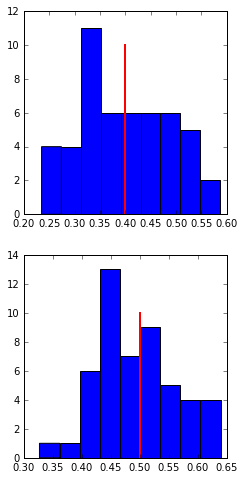

In [4]:
from delfi.utils.progress import no_tqdm, progressbar

n_fits = 50
out_snpe   = np.zeros((n_fits,2))

pbar = progressbar(total=n_fits)
desc = 'repeated fits'
pbar.set_description(desc)
with pbar:
    for idx_seed in range(n_fits):

        #print( str(idx_seed) + '/' + str(n_fits) )
        seed = 42 + idx_seed
        g.model.seed = seed
        g.prior.seed = seed

        N = 100
        data = g.gen(N, verbose=False)
        params, stats = data[0].reshape(-1), data[1].reshape(-1)

        normals = gauss_weights(data[0], data[1], mu_y, Sig_y)
        normals = np.ones(N) / N
        ahat =       alpha(params, stats, normals)
        bhat =        beta(params, stats, normals, ahat)
        gamma2hat = gamma2(params, stats, normals, ahat, bhat)

        mu_hat   = ahat + bhat * x0
        sig2_hat = gamma2hat

        out_snpe[idx_seed,:] = (mu_hat, sig2_hat)
        pbar.update(1)

plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.hist(out_snpe[:,0], bins=np.linspace(out_snpe[:,0].min(), out_snpe[:,0].max(), 10))
plt.plot([post.mean, post.mean], [0, 10], 'r', linewidth=2)
plt.subplot(2,2,3)
plt.hist(out_snpe[:,1], bins=np.linspace(out_snpe[:,1].min(), out_snpe[:,1].max(), 10))
plt.plot([post.std**2, post.std**2], [0, 10], 'r', linewidth=2)

plt.show()